## PropDRM - deep learning from propositionalized data structures

This notebook serves as an illustratory example of the PropDRM approach, proposed by Lavrač et al. (MLJ, 2020).
The key idea of PropDRM builds on the concept of Wordification (Chapter 3), coupled with modern deep neural networks. The implementation in this notebook follows the key ideas in the paper, however, for the C++ version of the code (the original), please consult: https://github.com/SkBlaz/PropStar

- python-rdm==0.3.5
- tabulate==0.8.7
- tensorflow >= 2.0
- shap>=0.37
- seaborn>=0.38
- matplotlib>=3.0.0

We begin by refreshing the notion of Wordification:

In [1]:
import csv
from IPython.display import HTML, display
import tabulate
with open('data/molecule.csv') as csvfile:
    rows = [row for row in csv.reader(csvfile)]
print('table "molecule"')
display(HTML(tabulate.tabulate(rows[:5], tablefmt='html', showindex=True)))

table "molecule"


0,molecule_id,ind1,inda,logp,lumo,mutagenic
1,varchar,integer,integer,float,float,varchar
2,primary key,,,,,
3,d1,1,0,4.23,-1.246,yes
4,d10,1,0,4.62,-1.387,yes


The Wordification is performed as done in Chapter 3.

In [2]:
from rdm.db import DBContext, CSVConnection
from rdm.db import OrangeConverter
from rdm.wrappers import Wordification

# Establish a connection
connection = CSVConnection(['data/molecule.csv','data/atom.csv','data/bond.csv'])
context = DBContext(connection, target_table='molecule', target_att='mutagenic')

# Convert relational context
conv = OrangeConverter(context)

/home/blazs/.local/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
from pprint import pprint

# We'll use TF-IDF scoring
wordificator = Wordification(conv.target_Orange_table(), conv.other_Orange_tables(), context, word_att_length=2)
wordificator.run()
wordificator.calculate_weights(measure='tfidf')
trains_tfidf = wordificator.to_orange()
feature_names = trains_tfidf.domain.attributes

In [8]:
import numpy as np
# Prepare for learning

X = molecules_tfidf.X
Y = molecules_tfidf.Y
y_names = np.array([x.name for x in trains_tfidf.domain.attributes])

# Let's do a 80:20 split
first_fifth = int(X.shape[0]/5)

# partition the data sets
X_test = X[0:first_fifth]
X_train = X[first_fifth:]
Y_test = Y[0:first_fifth]
Y_train = Y[first_fifth:]

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# A simple neural network with one hidden layer
model = keras.Sequential()
model.add(keras.Input(shape=(X_train.shape[1],)))
model.add(layers.Dense(8, activation="relu"))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, Y_train, epochs=100, batch_size=2, verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8)                 21232     
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 21,241
Trainable params: 21,241
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
76/76 [==============================] - 0s 1ms/step - loss: 5.6383 - accuracy: 0.5894
Epoch 2/100
76/76 [==============================] - 0s 1ms/step - loss: 2.4324 - accuracy: 0.6358
Epoch 3/100
76/76 [==============================] - 0s 1ms/step - loss: 1.9010 - accuracy: 0.6887
Epoch 4/100
76/76 [==============================] - 0s 1ms/step - loss: 2.2489 - a

76/76 [==============================] - 0s 1ms/step - loss: 0.3887 - accuracy: 0.7815
Epoch 76/100
76/76 [==============================] - 0s 1ms/step - loss: 0.3607 - accuracy: 0.7550
Epoch 77/100
76/76 [==============================] - 0s 992us/step - loss: 0.3662 - accuracy: 0.7417
Epoch 78/100
76/76 [==============================] - 0s 1ms/step - loss: 0.3837 - accuracy: 0.7351
Epoch 79/100
76/76 [==============================] - 0s 1ms/step - loss: 0.4102 - accuracy: 0.7219
Epoch 80/100
76/76 [==============================] - 0s 1ms/step - loss: 0.3787 - accuracy: 0.7219
Epoch 81/100
76/76 [==============================] - 0s 1ms/step - loss: 0.3741 - accuracy: 0.7550
Epoch 82/100
76/76 [==============================] - 0s 1ms/step - loss: 0.4101 - accuracy: 0.7351
Epoch 83/100
76/76 [==============================] - 0s 1ms/step - loss: 0.3657 - accuracy: 0.7285
Epoch 84/100
76/76 [==============================] - 0s 1ms/step - loss: 0.3954 - accuracy: 0.7285
Epoch 85/10

/home/blazs/miniconda3/envs/wordification/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Loss during training')

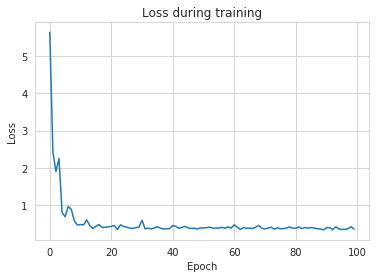

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.lineplot(list(range(len(history.history['loss']))),history.history['loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss during training")

In [11]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
predictions = [np.round(x) for x in predictions]
crep = classification_report(predictions, Y_test, output_dict = True)['accuracy']
print(f"Achieved Accuracy of {crep}")

Achieved Accuracy of 0.7567567567567568


PropDRM can also be explained by using SHAP tool. For this example, we will use the Trains data set from Chapter 3!

In [19]:
import requests
## Download the trains data set
request = requests.get('https://raw.githubusercontent.com/xflows/rdm/master/examples/data/trains/trains.csv')
with open("data/trains.csv", "wb") as file:
    file.write(request.content)
request = requests.get('https://raw.githubusercontent.com/xflows/rdm/master/examples/data/trains/cars.csv')
with open("data/cars.csv", "wb") as file:
    file.write(request.content)

# Establish a connection
connection = CSVConnection(['data/trains.csv','data/cars.csv'])
context = DBContext(connection, target_table='trains', target_att='direction')

# Convert relational context
conv = OrangeConverter(context)

# We'll use TF-IDF scoring
wordificator = Wordification(conv.target_Orange_table(), conv.other_Orange_tables(), context, word_att_length=2)
wordificator.run()
wordificator.calculate_weights(measure='tfidf')
trains_tfidf = wordificator.to_orange()
feature_names = trains_tfidf.domain.attributes


X = trains_tfidf.X
Y = trains_tfidf.Y
y_names = np.array([x.name for x in trains_tfidf.domain.attributes])

# Let's do a 80:20 split
first_fifth = int(X.shape[0]/5)

# partition the data sets
X_test = X[0:first_fifth]
X_train = X[first_fifth:]
Y_test = Y[0:first_fifth]
Y_train = Y[first_fifth:]

Next, we define a neural network architecture, as done before.

In [20]:
class NeuralNet:
    """
    A neural network class. This class serves during SHAP-based explanations for its predict_proba capability.
    """
    
    def __init__(self):
        
        ## Initialization of a generic neural network model
        self.model = keras.Sequential()
        self.model.add(keras.Input(shape=(X_train.shape[1],)))
        self.model.add(layers.Dense(8, activation="relu"))
        self.model.add(layers.Dropout(0.2))
        self.model.add(layers.Dense(1, activation="sigmoid"))
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    def fit(self, Xdata, Ydata):
        
        ## A sklearn-like fit function
        self.model.fit(Xdata, Ydata, epochs=100, batch_size=2, verbose=1)
        
    def predict_proba(self, Xdata):
        
        ## A sklearn-like predict_proba function
        return self.model.predict(Xdata)
        

The neural network is trained on the training data next.

In [21]:
import shap
import pandas as pd
shap.initjs()

neuralNetwork = NeuralNet()
neuralNetwork.fit(X_train, Y_train)

Epoch 1/100
8/8 [==============================] - 0s 1ms/step - loss: 0.7999 - accuracy: 0.5000
Epoch 2/100
8/8 [==============================] - 0s 1ms/step - loss: 0.5920 - accuracy: 0.6875
Epoch 3/100
8/8 [==============================] - 0s 769us/step - loss: 0.5897 - accuracy: 0.7500
Epoch 4/100
8/8 [==============================] - 0s 1ms/step - loss: 0.4684 - accuracy: 0.7500
Epoch 5/100
8/8 [==============================] - 0s 926us/step - loss: 0.5944 - accuracy: 0.6875
Epoch 6/100
8/8 [==============================] - 0s 1ms/step - loss: 0.3962 - accuracy: 0.8750
Epoch 7/100
8/8 [==============================] - 0s 1ms/step - loss: 0.3906 - accuracy: 0.9375
Epoch 8/100
8/8 [==============================] - 0s 864us/step - loss: 0.4702 - accuracy: 0.8125
Epoch 9/100
8/8 [==============================] - 0s 996us/step - loss: 0.4890 - accuracy: 0.7500
Epoch 10/100
8/8 [==============================] - 0s 778us/step - loss: 0.4151 - accuracy: 0.8125
Epoch 11/100
8/8 [=

8/8 [==============================] - 0s 704us/step - loss: 0.0681 - accuracy: 0.9375
Epoch 84/100
8/8 [==============================] - 0s 752us/step - loss: 0.0691 - accuracy: 0.9375
Epoch 85/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0834 - accuracy: 1.0000
Epoch 86/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0592 - accuracy: 0.9375
Epoch 87/100
8/8 [==============================] - 0s 888us/step - loss: 0.0160 - accuracy: 1.0000
Epoch 88/100
8/8 [==============================] - 0s 736us/step - loss: 0.0096 - accuracy: 1.0000
Epoch 89/100
8/8 [==============================] - 0s 755us/step - loss: 0.0089 - accuracy: 1.0000
Epoch 90/100
8/8 [==============================] - 0s 907us/step - loss: 0.0396 - accuracy: 1.0000
Epoch 91/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0295 - accuracy: 1.0000
Epoch 92/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0608 - accuracy: 0.9375
Epoch 93/100
8/8 [===

The SHAP tool expores how combinations of features effectively impact model output. The final results are the features that impacted the output the most.

In [24]:
# use Kernel SHAP to explain test set predictions
X_train = pd.DataFrame(X_train)
X_train.columns = feature_names
X_test = pd.DataFrame(X_test)
X_test.columns = feature_names
explainer = shap.KernelExplainer(neuralNetwork.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(X_test, nsamples=100)

Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.315e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=5.780e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 40 iterations, i.e. alpha=4.743e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 40 iterations, i.e. alpha=4.743e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropp

Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.843e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=2.583e-02, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=2.583e-02, with an active set of 13 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=2.583e-02, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropp

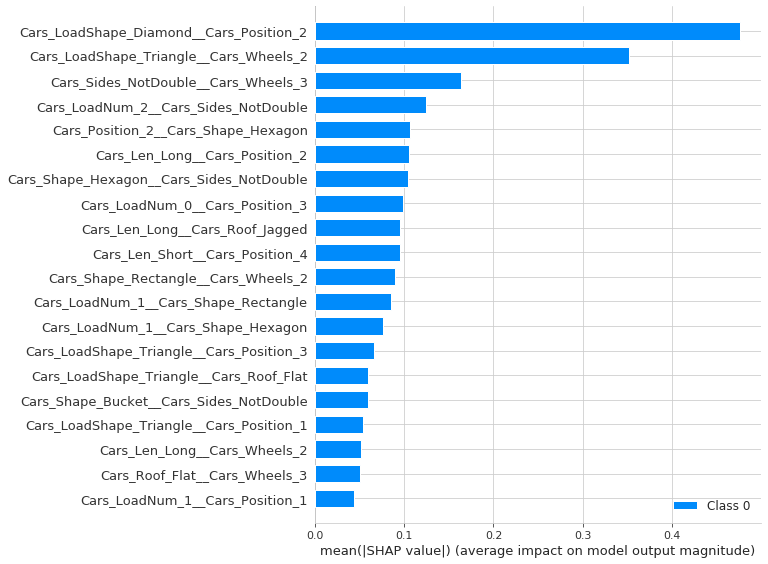

In [25]:
shap.summary_plot(shap_values, X_test) ## Plot the relevances of features on the model output!

The SHAP's plot offers direct insight into which features were the most relevant for the neural classifier. The first one, *Cars_LoadShape_Diamond_Cars_Position_2* indicates that the cart's shape and position are amongst the most relevant attributes.